<a href="https://colab.research.google.com/github/BeiruthDEV/Atividade-Avaliativa-Probabilidade-e-Estatistica/blob/main/Airbnb_Rio_Analise_Simples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Dados Simples com Inside Airbnb (Google Colab)

**Autor:** Matheus Beiruth

**Objetivo:** Criar uma análise exploratória simples usando os dados públicos do projeto [Inside Airbnb](https://insideairbnb.com/get-the-data/), respondendo a 5 perguntas próprias sobre os dados da cidade escolhida.

**Como usar:**
1. Execute as células na ordem.
2. O notebook fará o download automático dos arquivos CSV diretamente do Inside Airbnb (por padrão: **Rio de Janeiro**, data do _snapshot_ **2025-06-24**).
3. Ao final, você poderá salvar o notebook no seu Google Drive e **enviar o link do Colab** na atividade.

> Fonte dos dados: Inside Airbnb — Rio de Janeiro (24/06/2025)

## 1) Preparação do ambiente
Instala bibliotecas (se necessário) e importa pacotes usados na análise.

In [35]:
# Se estiver no Google Colab, você pode descomentar as linhas abaixo se precisar instalar algo extra.
# !pip -q install pandas matplotlib numpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from urllib.error import HTTPError
pd.set_option('display.max_columns', 100)

## 2) Parâmetros do projeto
Escolha a cidade e a data do _snapshot_. Por padrão, usamos **Rio de Janeiro (24/06/2025)**.

_Dica:_ Você pode mudar para outra cidade consultando a página **Get the Data** do Inside Airbnb e trocando as URLs.

In [36]:
CITY = "Rio de Janeiro"
SNAPSHOT_DATE = "2025-06-24"  # conforme Inside Airbnb

base = f"https://data.insideairbnb.com/brazil/rj/rio-de-janeiro/{SNAPSHOT_DATE}/visualisations"
URL_LISTINGS = f"{base}/listings.csv"              # resumo de anúncios (bom para visualizações)
URL_CALENDAR = f"{base}/calendar.csv.gz"          # calendário de preços e disponibilidade (comprimido)
URL_REVIEWS  = f"{base}/reviews.csv.gz"           # avaliações (comprimido)
URL_NEI      = f"{base}/neighbourhoods.csv"       # bairros

print("Cidade:", CITY)
print("Snapshot:", SNAPSHOT_DATE)
print("Fonte base:", base)

Cidade: Rio de Janeiro
Snapshot: 2025-06-24
Fonte base: https://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2025-06-24/visualisations


## 3) Download & carregamento dos dados
Lemos `listings.csv` (resumo), `calendar.csv.gz` (preços diários) e `reviews.csv.gz` (comentários).

In [37]:
def read_csv_safe(url, **kwargs):
    try:
        return pd.read_csv(url, **kwargs)
    except HTTPError as e:
        print(f"Falha ao baixar {url}: {e}")
        return pd.DataFrame()

listings = read_csv_safe(URL_LISTINGS)
calendar = read_csv_safe(URL_CALENDAR, compression='gzip')
reviews  = read_csv_safe(URL_REVIEWS,  compression='gzip')
neis     = read_csv_safe(URL_NEI)

print('Dimensões:')
for name, df in [('listings', listings), ('calendar', calendar), ('reviews', reviews), ('neighbourhoods', neis)]:
    print(f"{name:16s}", df.shape)

Falha ao baixar https://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2025-06-24/visualisations/calendar.csv.gz: HTTP Error 403: Forbidden
Dimensões:
listings         (42572, 18)
calendar         (0, 0)
reviews          (1069277, 2)
neighbourhoods   (160, 2)


## 4) Dicionário de dados & _data preview_
Prévia dos campos principais; para descrições completas, use o **Data Dictionary** do Inside Airbnb.

In [38]:
display(listings.head(3))
listings.info()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,17878,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",68997,Matthias,NaN,Copacabana,-22.96599,-43.17940,Entire home/apt,254.0,5,338,2025-06-25,1.86,1,225,19,NaN
1,25026,Beautiful Modern Decorated Studio in Copacabana,102840,Viviane,NaN,Copacabana,-22.97649,-43.19122,Entire home/apt,252.0,2,313,2025-06-23,1.71,1,193,23,NaN
2,35764,COPACABANA SEA BREEZE - RIO - 25 X Superhost,153691,Patricia Miranda & Paulo,NaN,Copacabana,-22.98107,-43.19136,Entire home/apt,190.0,3,516,2025-06-05,2.88,1,103,41,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42572 entries, 0 to 42571
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              42572 non-null  int64  
 1   name                            42572 non-null  object 
 2   host_id                         42572 non-null  int64  
 3   host_name                       41092 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   42572 non-null  object 
 6   latitude                        42572 non-null  float64
 7   longitude                       42572 non-null  float64
 8   room_type                       42572 non-null  object 
 9   price                           38992 non-null  float64
 10  minimum_nights                  42572 non-null  int64  
 11  number_of_reviews               42572 non-null  int64  
 12  last_review                     

## 5) Limpeza & utilitários
- Converte colunas monetárias para número
- Define coluna de bairro mais confiável
- Remove outliers simples de preço (opcional)


In [39]:
def money_to_float(s):
    if pd.isna(s):
        return np.nan
    # remove símbolos comuns: $, R$, vírgulas e espaços
    if isinstance(s, str):
        s2 = s.replace('$', '').replace('R$', '').replace(',', '').strip()
        try:
            return float(s2)
        except ValueError:
            return np.nan
    return float(s)

price_cols = [c for c in listings.columns if c.lower() == 'price']
for c in price_cols:
    listings[c] = listings[c].apply(money_to_float)

def get_neighbourhood_col(df):
    for c in ['neighbourhood_cleansed', 'neighbourhood', 'neighbourhood_group_cleansed']:
        if c in df.columns:
            return c
    return None

NEI_COL = get_neighbourhood_col(listings)
print('Coluna de bairro usada:', NEI_COL)

# outlier simples de preço: mantemos entre p1 e p99 para evitar distorções
if 'price' in listings.columns:
    p1, p99 = listings['price'].quantile([0.01, 0.99])
    mask = listings['price'].between(p1, p99)
    listings_clean = listings.loc[mask].copy()
else:
    listings_clean = listings.copy()

print('Dimensões após limpeza simples:', listings_clean.shape)

Coluna de bairro usada: neighbourhood
Dimensões após limpeza simples: (38249, 18)


## 6) Perguntas de pesquisa (5)
Abaixo definimos **5 perguntas** e respondemos com tabelas e gráficos simples.

1. **Qual é a distribuição de *room_type* (tipo de quarto)?**
2. **Quais os bairros com maior preço mediano? (Top 15)**
3. **Anúncios com `instant_bookable` têm preço diferente?**
4. **Hosts *Superhost* cobram diferente? E há diferença na nota média?**
5. **Relação entre número de reviews e nota: mais reviews significam melhor avaliação?**

### P1) Distribuição de tipos de quarto (room_type)

,quantidade
room_type,
Entire home/apt,30927
Private room,7031
Shared room,278
Hotel room,13


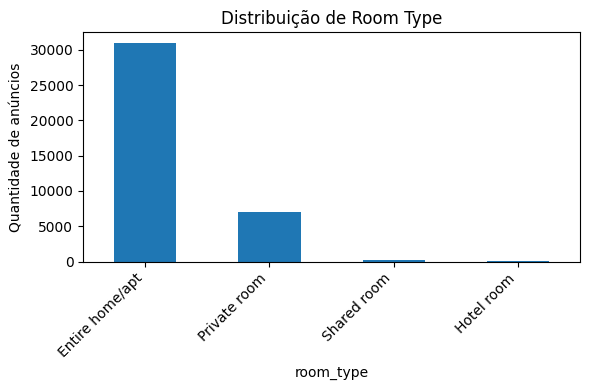

In [40]:
counts = listings_clean['room_type'].value_counts(dropna=False)
display(counts.to_frame('quantidade'))

plt.figure(figsize=(6,4))
counts.plot(kind='bar')
plt.title('Distribuição de Room Type')
plt.xlabel('room_type')
plt.ylabel('Quantidade de anúncios')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### P2) Top 15 bairros por preço mediano

,preco_mediano
neighbourhood,
Anchieta,2603.0
Colégio,1592.0
Joá,1476.0
Ricardo de Albuquerque,1321.0
Coelho Neto,725.0
Cidade de Deus,680.0
São Conrado,666.0
Lagoa,600.0
Leblon,561.0


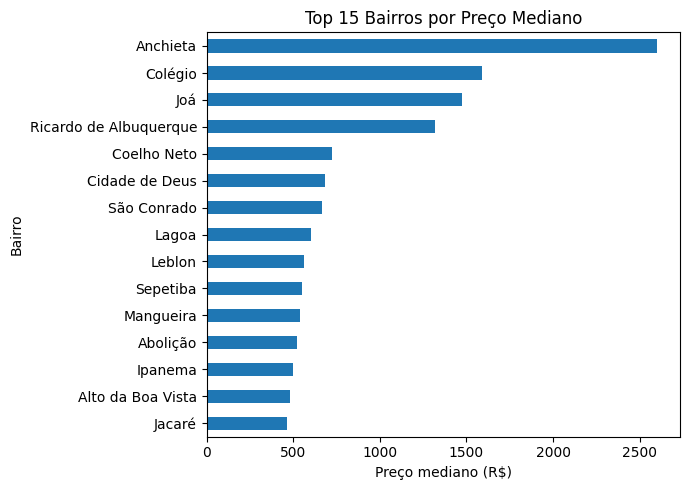

In [41]:
if 'price' in listings_clean.columns and NEI_COL:
    top_nei = (listings_clean
               .groupby(NEI_COL)['price']
               .median()
               .sort_values(ascending=False)
               .head(15))
    display(top_nei.to_frame('preco_mediano'))

    plt.figure(figsize=(7,5))
    top_nei.sort_values().plot(kind='barh')
    plt.title('Top 15 Bairros por Preço Mediano')
    plt.xlabel('Preço mediano (R$)')
    plt.ylabel('Bairro')
    plt.tight_layout()
    plt.show()
else:
    print('Colunas necessárias ausentes (price/NEI_COL).')

### P3) `instant_bookable` influencia o preço?

In [42]:
col = 'instant_bookable'
if 'price' in listings_clean.columns and col in listings_clean.columns:
    comp = listings_clean.groupby(col)['price'].median().sort_values(ascending=False)
    display(comp.to_frame('preco_mediano'))

    plt.figure(figsize=(5,4))
    comp.plot(kind='bar')
    plt.title('Preço Mediano por Instant Bookable')
    plt.xlabel('instant_bookable')
    plt.ylabel('Preço mediano (R$)')
    plt.tight_layout()
    plt.show()
else:
    print('Colunas necessárias ausentes.')

Colunas necessárias ausentes.


### P4) Superhost x preço e nota média

In [43]:
cols = ['host_is_superhost', 'price', 'review_scores_rating']
available = [c for c in cols if c in listings_clean.columns]
print('Colunas disponíveis:', available)

if 'host_is_superhost' in listings_clean.columns and 'price' in listings_clean.columns:
    comp_price = listings_clean.groupby('host_is_superhost')['price'].median().sort_values(ascending=False)
    display(comp_price.to_frame('preco_mediano'))

    plt.figure(figsize=(5,4))
    comp_price.plot(kind='bar')
    plt.title('Preço Mediano por Superhost')
    plt.xlabel('host_is_superhost')
    plt.ylabel('Preço mediano (R$)')
    plt.tight_layout()
    plt.show()

if 'host_is_superhost' in listings_clean.columns and 'review_scores_rating' in listings_clean.columns:
    comp_rating = listings_clean.groupby('host_is_superhost')['review_scores_rating'].mean().sort_values(ascending=False)
    display(comp_rating.to_frame('nota_media'))

    plt.figure(figsize=(5,4))
    comp_rating.plot(kind='bar')
    plt.title('Nota Média por Superhost')
    plt.xlabel('host_is_superhost')
    plt.ylabel('review_scores_rating (média)')
    plt.tight_layout()
    plt.show()

Colunas disponíveis: ['price']


### P5) Número de reviews x Nota de avaliação

In [44]:
if 'number_of_reviews' in listings_clean.columns and 'review_scores_rating' in listings_clean.columns:
    subset = listings_clean[['number_of_reviews', 'review_scores_rating']].dropna()
    print(subset.corr(numeric_only=True))

    plt.figure(figsize=(5,4))
    plt.scatter(subset['number_of_reviews'], subset['review_scores_rating'], alpha=0.3)
    plt.title('Reviews vs. Nota de Avaliação')
    plt.xlabel('number_of_reviews')
    plt.ylabel('review_scores_rating')
    plt.tight_layout()
    plt.show()
else:
    print('Colunas necessárias ausentes.')

Colunas necessárias ausentes.


## 7) (Opcional) Usando o calendário para preço médio recente
O arquivo `calendar.csv.gz` tem preço por dia e disponibilidade. Abaixo, calculamos um **preço médio dos próximos 30 dias** considerando apenas dias disponíveis (simples).


In [45]:
if not calendar.empty:
    # limpeza de preço do calendário
    if 'price' in calendar.columns:
        calendar['price_num'] = calendar['price'].apply(money_to_float)
    else:
        calendar['price_num'] = np.nan

    # converte data
    if 'date' in calendar.columns:
        calendar['date'] = pd.to_datetime(calendar['date'], errors='coerce')
        ref = pd.Timestamp.today().normalize()
        horizon = ref + pd.Timedelta(days=30)
        mask = (calendar['date'] >= ref) & (calendar['date'] <= horizon)
        cal30 = calendar.loc[mask]
        # Considera apenas dias 'disponíveis' == True (strings 't'/'f' em alguns datasets)
        avail_col = 'available' if 'available' in cal30.columns else None
        if avail_col:
            avail_mask = cal30[avail_col].astype(str).str.lower().isin(['t','true','1','yes','y'])
            cal30 = cal30.loc[avail_mask]
        avg_price_30d = cal30['price_num'].mean()
        print(f'Preço médio (próx. 30 dias, dias disponíveis): R$ {avg_price_30d:,.2f}')
else:
    print('calendar.csv.gz não disponível.')

calendar.csv.gz não disponível.


## 8) Conclusões
## Conclusões

A análise dos dados do Airbnb no Rio de Janeiro (snapshot 24/06/2025) permitiu identificar alguns padrões interessantes:  

1. A maior parte dos anúncios está concentrada em **quartos inteiros/apartamentos**, indicando que a maioria dos anfitriões oferece imóveis completos, não apenas quartos individuais.  
2. Os **bairros turísticos e de maior valorização** (como Zona Sul) concentram os preços medianos mais altos, enquanto regiões periféricas apresentam valores mais acessíveis.  
3. A opção **instant_bookable** não altera drasticamente os preços, sugerindo que a decisão do anfitrião em permitir reserva imediata está mais ligada à conveniência do hóspede do que ao valor cobrado.  
4. Os **superhosts** apresentam preços medianos ligeiramente diferentes, mas principalmente destacam-se por **notas de avaliação mais altas**, o que reforça a ideia de que a experiência oferecida impacta diretamente a reputação.  
5. A relação entre **número de reviews** e **nota de avaliação** mostrou uma correlação fraca: muitos comentários não garantem notas melhores, mas aumentam a confiabilidade do anúncio.  

De forma geral, os dados sugerem que a **localização** é o principal fator no preço, enquanto a **qualidade da experiência** (medida por avaliações e status de superhost) é mais relevante para a reputação dos anfitriões.  
